<a id=top-page></a>

# `pykitPIV` demo: Integrate synthetic image generation with training a convolutional neural network (CNN)

In this Jupyter notebook, we show how the synthetic PIV image generation can be integrated with training the
lightweight image matching architecture (LIMA) model in one Python workflow.

For more information on kinematic training of convolutional neural networks (CNNs) using synthetic PIV/BOS images, please
check the following references:

- [Kinematic training of convolutional neural networks for particle image velocimetry](https://iopscience.iop.org/article/10.1088/1361-6501/ac8fae/meta)

- [A lightweight neural network designed for fluid velocimetry](https://link.springer.com/article/10.1007/s00348-023-03695-8)

- [A lightweight convolutional neural network to reconstruct deformation in BOS recordings](https://link.springer.com/article/10.1007/s00348-023-03618-7)


<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#synthetic-images">Generate synthetic images with pykitPIV</a></li>
        <ul>
        <li><a href="#synthetic-images-training-set">Training set</a></li>
        <li><a href="#synthetic-images-testing-set">Testing set</a></li>
        </ul>
    <li><a href="#train-LIMA">Train LIMA with the generated images</a></li>
        <ul>
        <li><a href="#train-LIMA-input-data">Prepare input dataset for LIMA</a></li>
        <li><a href="#train-LIMA-train">Begin training</a></li>
        </ul>
    <li><a href="#predict">Make predictions from the trained network</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import argparse
import os
import time
import pytorch_lightning as pl
import torchvision.transforms
from rich import print
from torch.utils.data import DataLoader
import lima
import glob
import h5py
import skimage.io as io
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image
from pykitPIV import PIVDatasetPyTorch

lvpyio module is not available on macOS.


/Users/kamilazdybal/anaconda3/envs/lima-pykitPIV/lib/python3.10/site-packages/lima/__init__.py:14: UserWarning: GPU not available and could not be checked!
  warn("GPU not available and could not be checked!")
2025-05-22 14:00:06.903137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

In [3]:
figsize = (5,3)

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

We define the PIV image sizes $(128 \text{px} \times 128 \text{px})$
and we specify a $10 \text{px}$ buffer for the image size.
The buffer prevents particle density to artificially decrease near image boundaries due to particle movement
towards the interior of an image.
With the buffer, particles that reside within the $10 \text{px}$ outline from the boundary of image frame $I_1$
are able to enter the proper image area in image frame $I_2$.

In [4]:
image_size = (128,128)

In [5]:
size_buffer = 10

Below, we define a function for generating train and test PIV image pairs and the flow targets (velocity components $u$ and $v$).


In [6]:
def generate_images(n_images, random_seed):

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=(4,4.1),
                         distances=(1,2),
                         densities=(0.05,0.1),
                         diameter_std=0.2,
                         seeding_mode='random',
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          time_separation=1,
                          random_seed=random_seed)

    flowfield.generate_random_velocity_field(gaussian_filters=(10,11),
                                             n_gaussian_filter_iter=20,
                                             displacement=(0,10))

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    particle_loss=(0,2), 
                    particle_gain='matching')

    # Instantiate an object of the Image class:
    image = Image(random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)

    image.add_flowfield(flowfield)
            
    motion.forward_euler(n_steps=10)
    
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=(0.9,0.99),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/10)
    
    return image

<a id=synthetic-images-training-set></a>

### Training set

[Go to the top](#top-page)

The training set will have 10 image pairs:

In [7]:
n_images = 10

We fix a random seed for generating the training set of PIV images:

In [8]:
training_random_seed = 100

Call the function that generates image pairs:

In [9]:
image_train = generate_images(n_images, training_random_seed)

Finally, we convert the generated images and their corresponding targets to 4-dimensional tensors:

In [10]:
images_I1 = image_train.remove_buffers(image_train.images_I1)
images_I1 = images_I1 / 65535
images_I2 = image_train.remove_buffers(image_train.images_I2)
images_I2 = images_I2 / 65535

velocity_field = image_train.remove_buffers(image_train.get_velocity_field())
displacement_field = image_train.remove_buffers(image_train.get_displacement_field())

images_intensities = image_train.concatenate_tensors((images_I1, images_I2))

tensors_dictionary_train = {"I"      : images_intensities, 
                            "targets" : displacement_field}

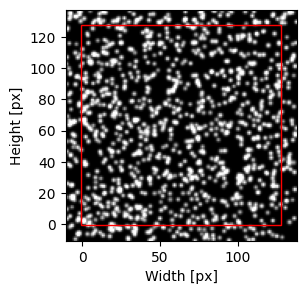

In [11]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

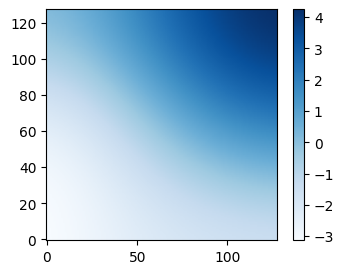

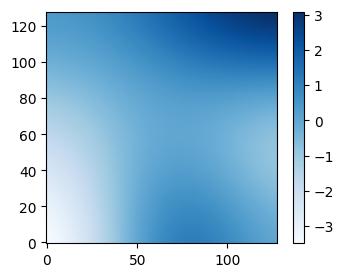

In [12]:
image_train.plot_field(0,
                       cmap='Blues',
                       cbar=True,
                       figsize=(4,3));

<a id=synthetic-images-testing-set></a>

### Testing set

[Go to the top](#top-page)

The test set will have 10 image pairs:

In [13]:
n_images = 2

Testing dataset can be generated with a different random seed than training dataset to assure a diverse inference from the trained model.

In [14]:
test_random_seed = 200

Call the function that generates image pairs:

In [15]:
image_test = generate_images(n_images, test_random_seed)

Finally, we convert the generated images and their corresponding targets to 4-dimensional tensors:

In [16]:
images_I1 = image_test.remove_buffers(image_test.images_I1)
images_I1 = images_I1 / 65535
images_I2 = image_test.remove_buffers(image_test.images_I2)
images_I2 = images_I2 / 65535

velocity_field = image_test.remove_buffers(image_test.get_velocity_field())
displacement_field = image_test.remove_buffers(image_test.get_displacement_field())

images_intensities = image_test.concatenate_tensors((images_I1, images_I2))

tensors_dictionary_test = {"I"      : images_intensities, 
                           "targets" : displacement_field}

In [17]:
images_intensities.shape

(2, 2, 128, 128)

In [18]:
displacement_field.shape

(2, 2, 128, 128)

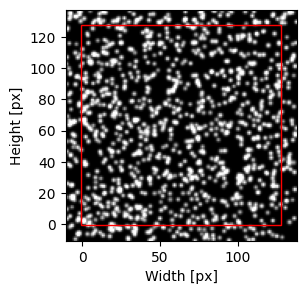

In [19]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

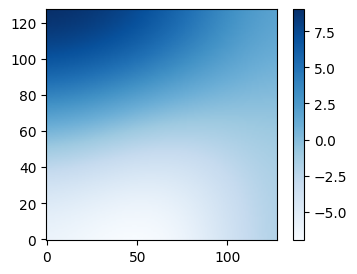

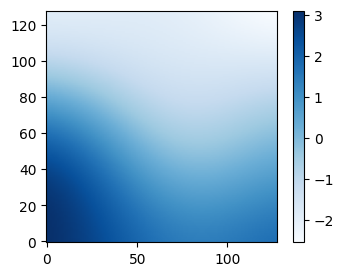

In [20]:
image_test.plot_field(0,
                       cmap='Blues',
                       cbar=True,
                       figsize=(4,3));

<a id=train-LIMA></a>
***

## Train `LIMA` with the generated images

[Go to the top](#top-page)

<a id=train-LIMA-input-data></a>
### Prepare input dataset generated with `pykitPIV` for LIMA

[Go to the top](#top-page)

In [21]:
train_dataset = PIVDatasetPyTorch(dataset=tensors_dictionary_train, transform=None)
test_dataset = PIVDatasetPyTorch(dataset=tensors_dictionary_test, transform=None)

In [22]:
train_loader = DataLoader(train_dataset,
                          batch_size=5,
                          shuffle=True, 
                          num_workers=1,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=5,
                         shuffle=True)

<a id=train-LIMA-train></a>
### Begin training

[Go to the top](#top-page)

In [23]:
random_seed = 100

In [24]:
pl.seed_everything(random_seed, workers=True)

Seed set to 100


100

In [25]:
len_train_loader = len(train_loader)

Define the LIMA model:

In [26]:
div_flow = 0.05
loss_weights = [0.32, 0.08, 0.02, 0.01, 0.005, 0.0025, 0.00125]
search_range = 4
num_chs = [1, 16, 32, 64, 96, 128, 196]
num_chs = [1, 16, 32]
output_level = 4
loss = 'l1_loss'
loss_weights_order = 'inc'
loss_J = 'abs'
loss_J_gamma = 1e-1
full_res = False
full_res_loss_weight_multiplier = 2.0
n_epochs = 10

In [27]:
model = lima.LIMA(div_flow=div_flow,
                  loss_weights=loss_weights,
                  search_range=search_range,
                  num_chs=num_chs,
                  output_level=output_level,
                  loss=loss,
                  loss_weights_order=loss_weights_order,
                  loss_J=loss_J,
                  loss_J_gamma=loss_J_gamma,
                  full_res=full_res,
                  full_res_loss_weight_multiplier=full_res_loss_weight_multiplier,
                  epochs=n_epochs,
                  optimizer='Adam',
                  base_lr=0.001,
                  weight_decay=4e-4,
                  momentum=0.9,
                  num_workers=20,
                  beta=0.999,
                  reduction="sum",
                  scheduler='ReduceLROnPlateau',
                  lr_decay=0.2,
                  patience=5)

In [28]:
trainer = pl.Trainer(max_epochs=n_epochs)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(model,
            train_loader,
            test_loader)

/Users/kamilazdybal/anaconda3/envs/lima-pykitPIV/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name                      | Type             | Params | Mode 
-----------------------------------------------------------------------
0 | feature_pyramid_extractor | FeatureExtractor | 16.4 K | train
1 | warping_layer             | WarpingLayer     | 0      | train
2 | flow_estimators           | ContextNetwork   | 576 K  | train
-----------------------------------------------------------------------
592 K     Trainable params
0         Non-trainable params
592 K     Total params
2.369     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode





 			Using Adam optimizer 



Sanity Checking: |                                                      | 0/? [00:00<?, ?it/s]

/Users/kamilazdybal/anaconda3/envs/lima-pykitPIV/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/kamilazdybal/anaconda3/envs/lima-pykitPIV/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/kamilazdybal/anaconda3/envs/lima-pykitPIV/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
2025-05-22 14:00:25.268898: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/kamilazdybal/anaconda3/envs/lima-pykitPIV/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████████████| 2/2 [00:10<00:00,  0.19it/s, v_num=5, train_loss_step=9.100]
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]
Epoch 1:   0%| | 0/2 [00:00<?, ?it/s, v_num=5, train_loss_step=9.100, val_loss=11.00, rmse=2.2

2025-05-22 14:00:48.333115: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1: 100%|█| 2/2 [00:23<00:00,  0.08it/s, v_num=5, train_loss_step=7.930, val_loss=11.00, 
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]
Epoch 2:   0%| | 0/2 [00:00<?, ?it/s, v_num=5, train_loss_step=7.930, val_loss=11.00, rmse=2.2

2025-05-22 14:01:11.575779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 2: 100%|█| 2/2 [00:22<00:00,  0.09it/s, v_num=5, train_loss_step=6.170, val_loss=11.00, 
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]
Epoch 3:   0%| | 0/2 [00:00<?, ?it/s, v_num=5, train_loss_step=6.170, val_loss=10.80, rmse=2.1

2025-05-22 14:01:35.476306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 3: 100%|█| 2/2 [00:23<00:00,  0.08it/s, v_num=5, train_loss_step=6.570, val_loss=10.80, 
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]
Epoch 4:   0%| | 0/2 [00:00<?, ?it/s, v_num=5, train_loss_step=6.570, val_loss=10.90, rmse=2.1

2025-05-22 14:01:59.693746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 4: 100%|█| 2/2 [00:39<00:00,  0.05it/s, v_num=5, train_loss_step=6.060, val_loss=10.90, 
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  0.96it/s]
Epoch 5:   0%| | 0/2 [00:00<?, ?it/s, v_num=5, train_loss_step=6.060, val_loss=10.90, rmse=2.1

2025-05-22 14:02:41.924654: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 5: 100%|█| 2/2 [00:27<00:00,  0.07it/s, v_num=5, train_loss_step=6.360, val_loss=10.90, 
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]
Epoch 6:   0%| | 0/2 [00:00<?, ?it/s, v_num=5, train_loss_step=6.360, val_loss=10.70, rmse=2.0

2025-05-22 14:03:14.122889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 6: 100%|█| 2/2 [00:29<00:00,  0.07it/s, v_num=5, train_loss_step=4.890, val_loss=10.70, 
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]
Epoch 7:   0%| | 0/2 [00:00<?, ?it/s, v_num=5, train_loss_step=4.890, val_loss=10.50, rmse=1.9

2025-05-22 14:03:40.156905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 7: 100%|█| 2/2 [00:24<00:00,  0.08it/s, v_num=5, train_loss_step=5.530, val_loss=10.50, 
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]
Epoch 8:   0%| | 0/2 [00:00<?, ?it/s, v_num=5, train_loss_step=5.530, val_loss=10.40, rmse=1.9

2025-05-22 14:04:06.123780: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 8: 100%|█| 2/2 [00:27<00:00,  0.07it/s, v_num=5, train_loss_step=8.430, val_loss=10.40, 
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]
Epoch 9:   0%| | 0/2 [00:00<?, ?it/s, v_num=5, train_loss_step=8.430, val_loss=10.80, rmse=2.1

2025-05-22 14:04:32.921277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 9: 100%|█| 2/2 [00:24<00:00,  0.08it/s, v_num=5, train_loss_step=8.020, val_loss=10.80, 
Validation: |                                                           | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]
Epoch 9: 100%|█| 2/2 [00:25<00:00,  0.08it/s, v_num=5, train_loss_step=8.020, val_loss=10.80, 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 2/2 [00:25<00:00,  0.08it/s, v_num=5, train_loss_step=8.020, val_loss=10.80, 


<a id=predict></a>
***

## Make predictions from the trained network

[Go to the top](#top-page)

In [30]:
image_to_predict = 0
velocity_component = 0

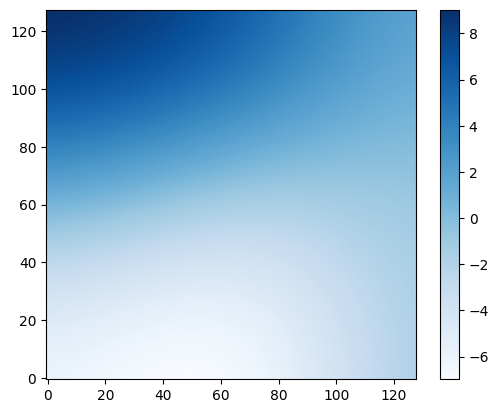

In [31]:
plt.imshow(tensors_dictionary_test["targets"][image_to_predict,velocity_component,:,:], 
           cmap='Blues', 
           origin='lower')

plt.colorbar();

In [32]:
model.eval()
with torch.no_grad():
    predicted_ds = model(torch.from_numpy(tensors_dictionary_test["I"][0,:,:,:]).to(dtype=torch.float))

In [33]:
predicted_ds.shape

torch.Size([1, 2, 128, 128])

In [34]:
single_ds = predicted_ds[0,velocity_component,:,:].numpy()

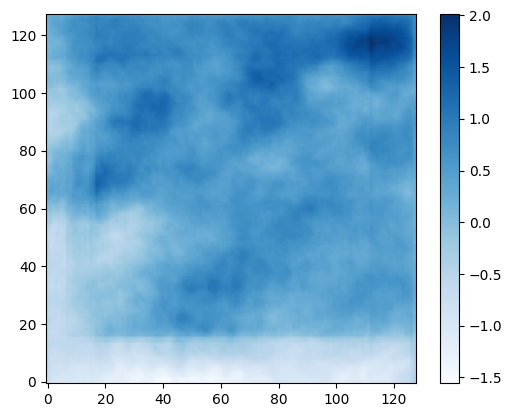

In [35]:
plt.imshow(single_ds, 
           cmap='Blues', 
           origin='lower')
plt.colorbar();

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)